# Hate Speech Detection using LSTM

This notebook presents a deep learning approach for detecting hate speech, offensive language, and neutral comments. The model utilizes a Bidirectional LSTM network, preceded by robust text preprocessing and word embeddings.

## 1. Setup and Library Imports

This section handles all necessary library imports, NLTK data downloads and deep learning using TensorFlow/Keras.

In [1]:
import numpy as np
import pandas as pd
import string
import re
import warnings

import matplotlib.pyplot as plt
import seaborn as sb
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 2. Dataset loading
labeled dataset of comments containing hate speech, offensive language, and neutral content. Each comment is associated with a label:

0 → Hate

1 → Offensive

2 → Neutral

In [ ]:
df = pd.read_csv('dataset\Labeled_Dataset_v1.csv')

### Initial Class Distribution: This pie chart shows the breakdown of labels in the raw dataset.

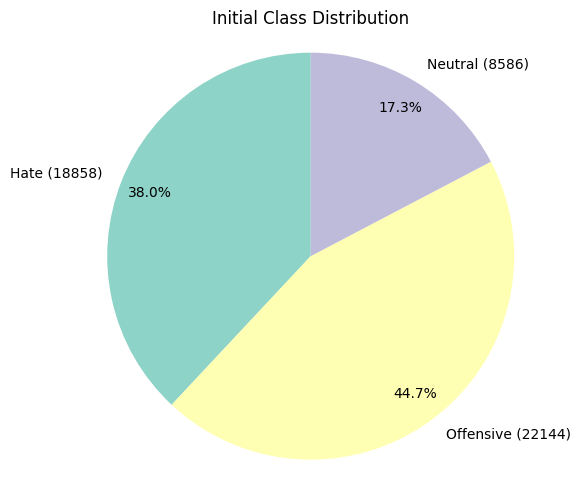

label
0.0    18858
1.0    22144
2.0     8586
Name: count, dtype: int64


In [3]:
label_order = [0, 1, 2]
label_counts = df['label'].value_counts().sort_index()

labels = ['Hate', 'Offensive', 'Neutral']
colors = sb.color_palette('Set3')[0:len(labels)]

plt.figure(figsize=(6, 5))
plt.pie(label_counts,
        labels=[f'{labels[i]} ({label_counts[i]})' for i in label_order],
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.85)
plt.title('Initial Class Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()
print(label_counts)

## 3. Class Balancing

To address potential class imbalance, a sampling strategy is applied. The `sampling_config` dictionary defines whether to oversample, undersample, or keep each class as is. The resulting balanced dataset's distribution is then visualized.

**Note:** Currently, the configuration is set to specific sample sizes, and undersampling is applied to the 'Hate' class.

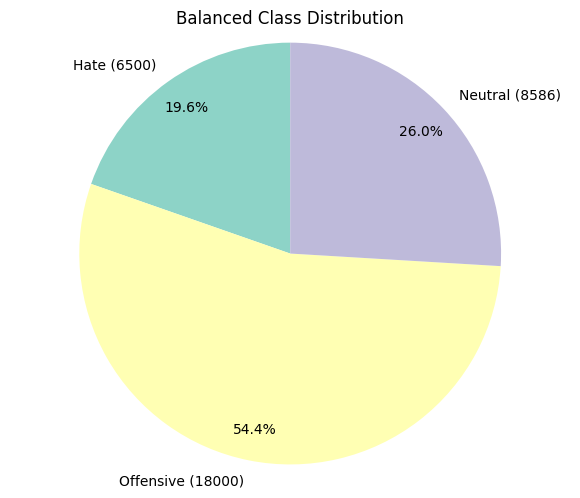

label
0.0     6500
1.0    18000
2.0     8586
Name: count, dtype: int64


In [4]:
SEED = 42
# Format: {label: (strategy, target_sample_size)}
# strategy: 'none', 'oversample', 'undersample'
sampling_config = {
    0: ('undersample', 6500),   # Hate
    1: ('undersample', 18000), # Offensive
    2: ('none', 8000)   # Neutral
}
sampled_dfs = []

for label, (strategy, target_size) in sampling_config.items():
    df_label = df[df['label'] == label]

    if strategy == 'none':
        sampled_dfs.append(df_label)

    elif strategy == 'undersample':
        sampled = df_label.sample(n=min(target_size, len(df_label)), random_state=SEED)
        sampled_dfs.append(sampled)

    elif strategy == 'oversample':
        sampled = df_label.sample(n=target_size, replace=True, random_state=SEED)
        sampled_dfs.append(sampled)

# Combine and shuffle
balanced_df = pd.concat(sampled_dfs, axis=0).sample(frac=1, random_state=SEED).reset_index(drop=True)

# Visualize final class distribution
label_order = [0, 1, 2]
labels = ['Hate', 'Offensive', 'Neutral']
label_counts = balanced_df['label'].value_counts().sort_index()

colors = sb.color_palette('Set3')[0:len(labels)]

plt.figure(figsize=(6, 5))
plt.pie(label_counts,
        labels=[f'{labels[i]} ({label_counts[i]})' for i in label_order],
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.85)

plt.title('Balanced Class Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()
print(label_counts)

## 4. Text Preprocessing

This crucial step cleans and normalizes the text data. The `preprocess_text` function performs:
- Lowercasing
- Removal of URLs, mentions, and hashtags
- Removal of numbers and punctuation
- Tokenization
- Stop word removal
- Lemmatization

In [5]:
def preprocess_text(text):
    text = text.lower()

    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)

    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    cleaned_tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 2
    ]

    return " ".join(cleaned_tokens)
balanced_df['comments'] = balanced_df['comments'].apply(preprocess_text)

balanced_df.sample(n=5, random_state=30)

,comments,label,class
8994,faggot,1.0,offensive
31954,attached photo post,2.0,neutral
16076,briahna told best advice ever gave aint nothin...,1.0,offensive
23602,honestly dont get online poll result,2.0,\tneutral
2404,folder contains one format,2.0,neutral


### Word Cloud: Visualizing the most frequent terms in neutral comments after preprocessing.

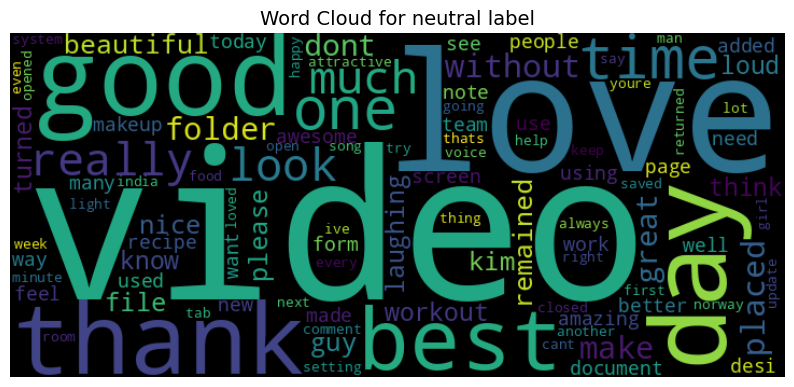

In [6]:
def plot_word_cloud(data, typ):
    corpus = " ".join(data['comments'])
    wc = WordCloud(max_words=100, width=720, height=320, collocations=False).generate(corpus)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {typ} label", fontsize=14)
    plt.show()
plot_word_cloud(balanced_df[balanced_df['label'] == 2], typ="neutral")

## 5. Model Preparation: Tokenization and Padding

For the LSTM model, text data needs to be converted into numerical sequences.
- A `Tokenizer` is fitted on the training data to create a vocabulary.
- Text sequences are generated from the tokenized vocabulary.
- `pad_sequences` ensures all input sequences have a uniform length, which is required for neural networks.

In [7]:
X_lstm = balanced_df['comments']
Y_lstm = pd.get_dummies(balanced_df['label'])
X_lstm_train, X_lstm_val, Y_lstm_train, Y_lstm_val = train_test_split(X_lstm, Y_lstm, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=10000, lower=True, split=' ')
tokenizer.fit_on_texts(X_lstm_train)

X_lstm_train_seq = tokenizer.texts_to_sequences(X_lstm_train)
X_lstm_val_seq = tokenizer.texts_to_sequences(X_lstm_val)

X_lstm_train_padded = pad_sequences(X_lstm_train_seq, maxlen=100, padding='post', truncating='post')
X_lstm_val_padded = pad_sequences(X_lstm_val_seq, maxlen=100, padding='post', truncating='post')

## 6. Bidirectional LSTM Model Definition and Training

A Sequential Keras model is defined using:
- An `Embedding` layer to convert numerical word indices into dense vectors.
- A `Bidirectional LSTM` layer to capture context from both directions of the sequence.
- `Dense` layers with `ReLU` activation, `BatchNormalization`, and `Dropout` for feature learning and regularization.
- A final `Dense` layer with `softmax` activation for multi-class classification.

The model is compiled with `categorical_crossentropy` loss and `Adam` optimizer. `EarlyStopping` and `ReduceLROnPlateau` callbacks are used to manage training and prevent overfitting.

In [8]:
lstm_model = keras.models.Sequential([
    layers.Embedding(input_dim=10000, output_dim=32, input_length=100),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])
lstm_model.build(input_shape=(None, 100))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,755 (1.32 MB)

 Trainable params: 345,731 (1.32 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = lstm_model.fit(X_lstm_train_padded, Y_lstm_train,
                         validation_data=(X_lstm_val_padded, Y_lstm_val),
                         epochs=10, batch_size=32,
                         callbacks=[es, lr])

Epoch 1/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 64s 71ms/step - accuracy: 0.7888 - loss: 2.0890 - val_accuracy: 0.8701 - val_loss: 0.4129 - learning_rate: 0.0010
Epoch 2/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 80s 69ms/step - accuracy: 0.9100 - loss: 0.3089 - val_accuracy: 0.8040 - val_loss: 0.5211 - learning_rate: 0.0010
Epoch 3/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 83s 70ms/step - accuracy: 0.9253 - loss: 0.2538 - val_accuracy: 0.8765 - val_loss: 0.3851 - learning_rate: 0.0010
Epoch 4/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 57s 69ms/step - accuracy: 0.9407 - loss: 0.2113 - val_accuracy: 0.8711 - val_loss: 0.4398 - learning_rate: 0.0010
Epoch 5/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 57s 69ms/step - accuracy: 0.9488 - loss: 0.1859 - val_accuracy: 0.8658 - val_loss: 0.4266 - learning_rate: 0.0010
Epoch 6/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - accuracy: 0.9585 - loss: 0.1479 - val_accuracy: 0.8676 - val_loss: 0.5003 - learning_rate: 5.0000e-04


### Training History Plots: These graphs show the model's loss and accuracy during training and validation over epochs.

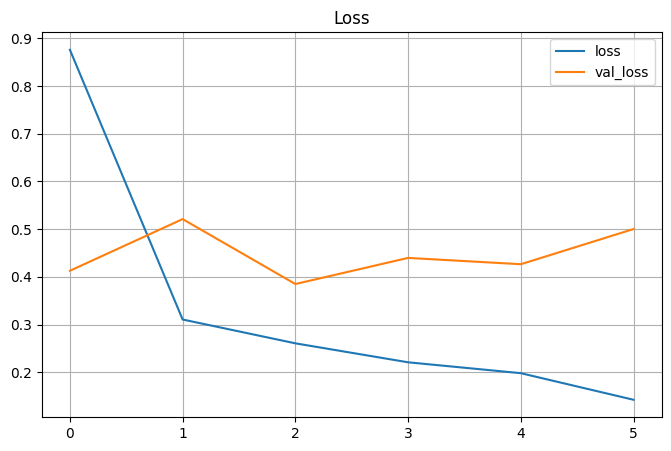

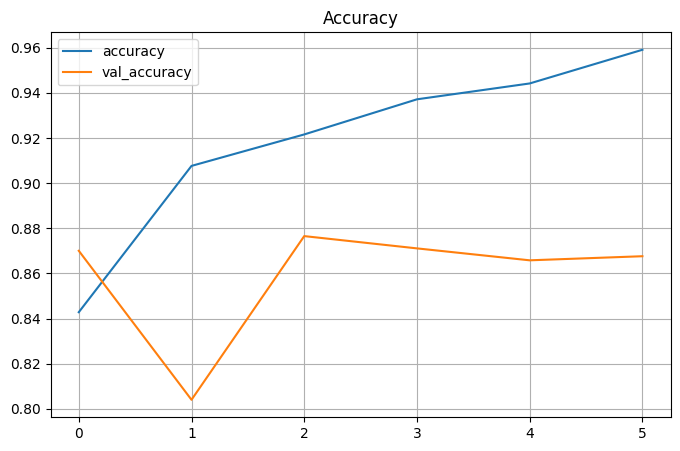

In [10]:
plt.figure(figsize=(8, 5))
pd.DataFrame(history.history)[['loss','val_loss']].plot(title="Loss", ax=plt.gca())
plt.grid(True)

plt.figure(figsize=(8, 5))
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(title="Accuracy", ax=plt.gca())
plt.grid(True)

plt.show()

## 7. Model Evaluation

The trained LSTM model's performance is evaluated on the validation set.
- Loss and Accuracy curves are plotted to visualize training progress.
- A classification report provides precision, recall, and F1-score for each class.
- A confusion matrix is displayed, showing the percentage of true vs. predicted labels.

207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step

               precision    recall  f1-score   support

        Hate       0.75      0.66      0.70      1320
   Offensive       0.90      0.91      0.90      3569
     Neutral       0.91      0.98      0.95      1729

    accuracy                           0.88      6618
   macro avg       0.85      0.85      0.85      6618
weighted avg       0.87      0.88      0.87      6618



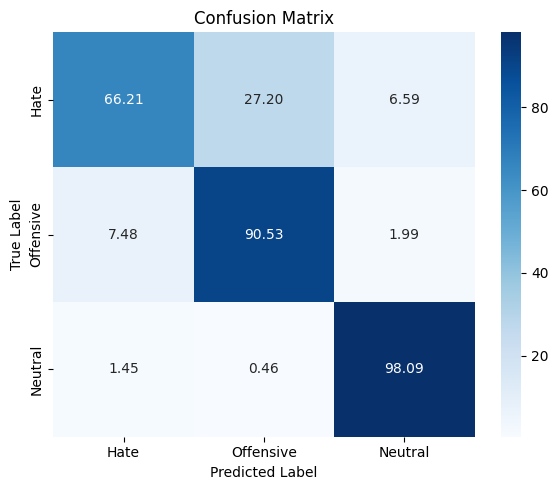

In [11]:
val_preds = lstm_model.predict(X_lstm_val_padded)
y_pred_labels = val_preds.argmax(axis=1)
y_true_labels = Y_lstm_val.values.argmax(axis=1)

label_names = ['Hate', 'Offensive', 'Neutral']
print("\n", classification_report(y_true_labels, y_pred_labels, target_names=label_names))

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6, 5))
sb.heatmap(100*cm / cm.sum(axis=1, keepdims=True), annot=True, fmt=".2f", cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [12]:
val_loss, val_acc = lstm_model.evaluate(X_lstm_val_padded, Y_lstm_val)
print(f"Validation Accuracy: {val_acc:.2f}")

207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8670 - loss: 0.3982
Validation Accuracy: 0.88


## 8. Prediction on Custom Examples

This section demonstrates how the trained LSTM model predicts the class of new, unseen text inputs.

In [15]:
def predict(texts):
    label_map = {0: 'Hate', 1: 'Offensive', 2: 'Neutral'}

    cleaned = [preprocess_text(t) for t in texts]

    seqs = tokenizer.texts_to_sequences(cleaned)
    padded = pad_sequences(seqs, maxlen=100, padding='post', truncating='post')

    probs = lstm_model.predict(padded)
    labels = np.argmax(probs, axis=-1)

    # snow results
    for i, text in enumerate(texts):
        print(f"\n🔍 Text: \"{text}\"")
        print(f"Prediction → {label_map[labels[i]]}")
        print("Confidence → " + ", ".join([
            f"{label_map[j]}: {probs[i][j]:.2f}" for j in range(3)
        ]))


In [14]:
texts = [
    # --- Neutral ---
    "Can’t wait to see this again!",
    "i love dogs",
    "Let's grab coffee tomorrow.",
    "That was a great movie!",

    # --- Offensive  ---
    "fuck you bitch",
    "You're so annoying, just go away bitch.",

    # --- Hate  ---
    "Go back to your country.",
    "People like you shouldn't exist.",
    "I hate all of you.",
    "You're a disgusting [slur]."
]
predict(texts)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

🔍 Text: "Can’t wait to see this again!"
Prediction → Neutral
Confidence → Hate: 0.07, Offensive: 0.09, Neutral: 0.84

🔍 Text: "i love dogs"
Prediction → Neutral
Confidence → Hate: 0.00, Offensive: 0.01, Neutral: 0.99

🔍 Text: "Let's grab coffee tomorrow."
Prediction → Neutral
Confidence → Hate: 0.00, Offensive: 0.00, Neutral: 1.00

🔍 Text: "That was a great movie!"
Prediction → Neutral
Confidence → Hate: 0.00, Offensive: 0.00, Neutral: 1.00

🔍 Text: "fuck you bitch"
Prediction → Offensive
Confidence → Hate: 0.12, Offensive: 0.87, Neutral: 0.00

🔍 Text: "You're so annoying, just go away bitch."
Prediction → Offensive
Confidence → Hate: 0.13, Offensive: 0.87, Neutral: 0.00

🔍 Text: "Go back to your country."
Prediction → Hate
Confidence → Hate: 0.42, Offensive: 0.41, Neutral: 0.17

🔍 Text: "People like you shouldn't exist."
Prediction → Hate
Confidence → Hate: 0.74, Offensive: 0.25, Neutral: 0.01

🔍 Text: "I hate all of you."
Prediction → Neutral
Co